In [1]:
import os, math, sys, random
import numpy as np
import numpy.linalg as la
import scipy.stats as st
import scipy.optimize as sopt
import matplotlib as mpl
import matplotlib.pyplot as plt

[[1]] 
 [[400.]] 
 [[4.]]


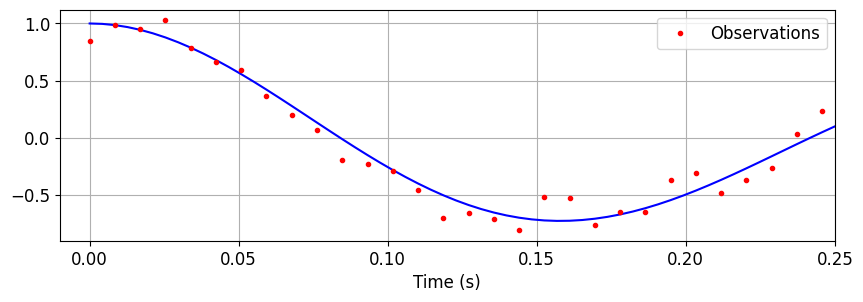

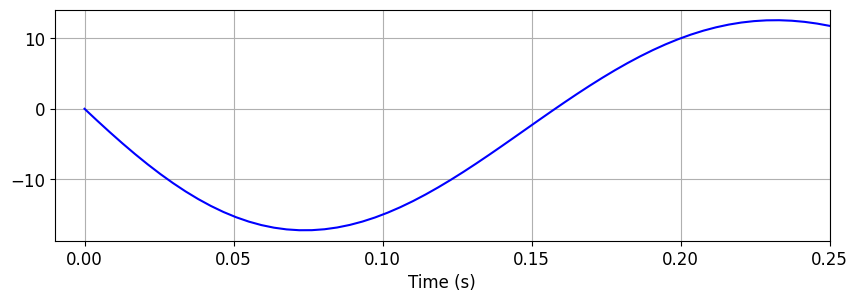

In [2]:
dof = 1 # degree of freedom
Y0   = [1,0] # initial conditions, [disp(3), vel(3)]
mVec = [1] # mass vector
kVec = [400] # stiffness vector
cVec = [4] # damping vector
noiseSigma = 0.1
 # measurement noise strength
obsInd = 0 # what state to observe
T = 0.25 # total time for forward integration
sampFac = 2 # sample every sampFac time step ORIGINAL VALUE = 8
tgrd = int(240*T) # time integration grid

Kmat = np.zeros((dof,dof))
Cmat = np.zeros((dof,dof))
Mmat = np.diag(mVec)
Kmat[0,:] = [kVec[0]]
Cmat[0,:] = [cVec[0]]
print(Mmat,'\n',Kmat,'\n',Cmat)

Zmat = np.zeros((2*dof,2*dof))
Zmat[0:dof,dof:] = np.diag([-1]*dof)
Zmat[dof:,0:dof] = la.inv(Mmat)@Kmat
Zmat[dof:,dof:] = la.inv(Mmat)@Cmat
lamda,V = la.eig(Zmat)
aVec = la.inv(V)@Y0
#aVec = [100,0,0,0,0,0]
def Y_mdof(t):
    lamdaMat = np.diag(np.exp(-lamda*t))
    return np.real(V@lamdaMat@aVec)

### Synthetic Data ###

Ytrue=np.zeros((2*dof,tgrd))
tlist = np.linspace(0,T,tgrd)
for i in range(0,tgrd):
    Ytrue[:,i] = Y_mdof(tlist[i])
np.random.seed(116)
Ynoisy = Ytrue[obsInd,0:] + noiseSigma*np.random.normal(0,1,tgrd)
Yobs = Ynoisy[0::sampFac]
tobs = tlist[0::sampFac]

np.savetxt('Ydata.dat',Yobs)
np.savetxt('Xdata.dat',tobs)
np.savetxt('init.dat',Y0)

### Plotting ###

mpl.rcParams.update({'font.size':12})
for j in range(0,2*dof):
    f, ax = plt.subplots(1, figsize=(10,3))
    plt.plot(tlist,Ytrue[j,:],'b-')
    if j == obsInd:
        plt.plot(tobs,Yobs,'r.',label='Observations')
        #plt.plot(tobs,Yobs,'r-')
        #plt.plot(tobs,Yobs,'r-')
        plt.legend(loc='upper right', numpoints = 1)
    plt.grid(True)
    plt.xlabel('Time (s)')
    # plt.ylabel(r'Displacement: $u_'+str(j+1)+'$')
    plt.xlim([-0.01,T])
    plt.ticklabel_format(style='sci', axis='y', scilimits=(-3,3))
    # plt.ylim([-1.1,1.1])
# plt.savefig('figs/Yobs.eps',bbox_inches='tight')

In [3]:
#True grid for forecast
T_true = 1
tgrd_true = 240*T_true
tlist_true = np.linspace(0,T_true,tgrd_true)

dof = 1 # degree of freedom
Npar = 2 # number of unknown parameters
obsInd = 0 # what state was observed
# phiTrue = [0,1e5]
phiTrue = [4,400]
X_low = [0,0]
X_up = [20,1000]
mylabel = [r'$c$', r'$k$']
mydof = ['Displacement [m]','Velocity [m/s]']

# Y0 = np.loadtxt('init.dat')
# Yobs = np.loadtxt('Ydata.dat')
# tobs = np.loadtxt('Xdata.dat')
Nobs = np.size(Yobs)

def loglikfun(parVecIn):
    mVec = [1]*dof # mass vector
    cVec = [parVecIn[0]] # stiffness vector
    kVec = [parVecIn[1]] # stiffness vector
    noiseSig = noiseSigma 
    Kmat = np.zeros((dof,dof))
    Cmat = np.zeros((dof,dof))
    Mmat = np.diag(mVec)
    Kmat[0,:] = [kVec[0]]
    Cmat[0,:] = [cVec[0]]
    Zmat = np.zeros((2*dof,2*dof))
    Zmat[0:dof,dof:] = np.diag([-1]*dof)
    Zmat[dof:,0:dof] = la.inv(Mmat)@Kmat
    Zmat[dof:,dof:] = la.inv(Mmat)@Cmat
    lamda,V = la.eig(Zmat)
    aVec = la.inv(V)@Y0
    #aVec = [100,0,0,0,0,0]
    loglikfun = 0.0
    for i in range(0,Nobs):
        tempVec = np.exp(-lamda*tobs[i])
        lamdaMat = np.diag(tempVec)
        Yresp = np.real(V@lamdaMat@aVec)
        loglikfun = loglikfun + (Yobs[i] - Yresp[obsInd])**2
    return -loglikfun/(2.0*noiseSig**2) - np.log(noiseSig)

def logpriorpdf(parVecIn):
        logprior = 0.0
        #logprior = logprior + rv2.logpdf(parVecIn[3])
        return logprior
def logpostprob(phiIn):
    #return logpriorpdf(phiIn) + loglikfun(phiIn)
    return loglikfun(phiIn)
def negativeloglik(phiIn):
    return -logpostprob(phiIn)

In [4]:
Ngrd  = 100
LogLikelihood = np.zeros((Ngrd,Ngrd))
Par1bnd = [0,10]
Par2bnd = [0,1000]
Par1rng = np.linspace(Par1bnd[0],Par1bnd[1],Ngrd)
Par2rng  = np.linspace(Par2bnd[0],Par2bnd[1],Ngrd)
Par1grd,Par2grd = np.meshgrid(Par1rng,Par2rng)
for i in range(0,Ngrd):
    for j in range(0, Ngrd):
        ParCur = np.array([Par1grd[i,j],Par2grd[i,j]])
        LogLikelihood[i,j] = np.exp(loglikfun(ParCur))



([<matplotlib.axis.YTick at 0x7f8b8ea45b80>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

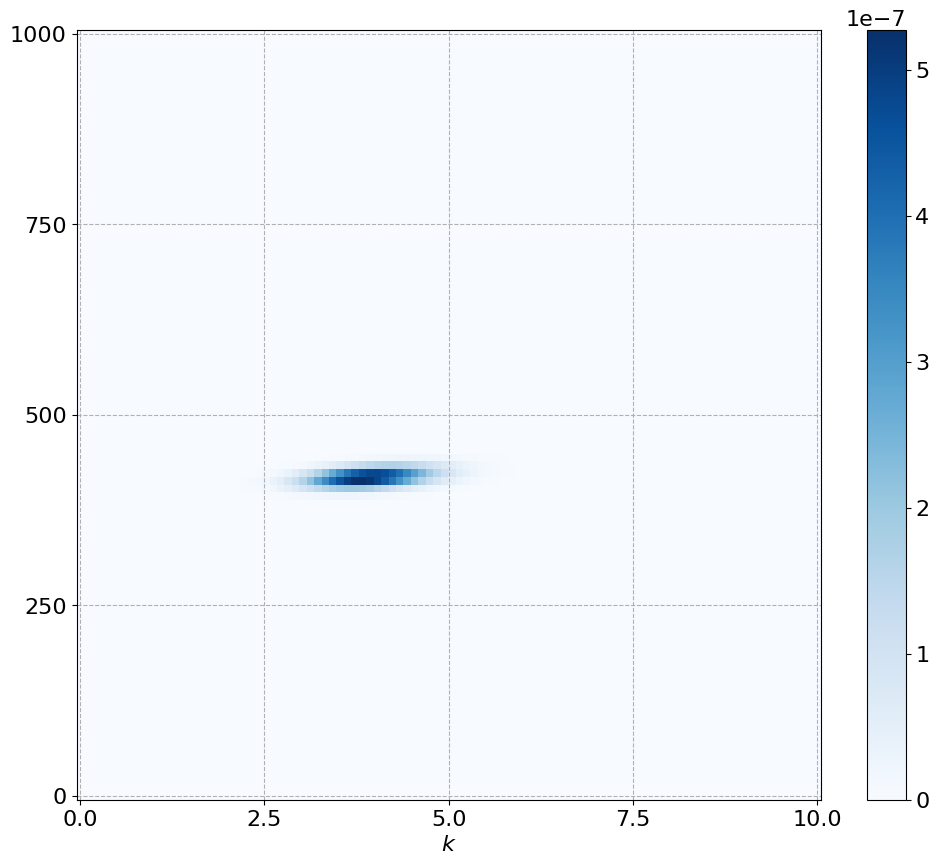

In [5]:
mpl.rcParams.update({'font.size':16})
#mpl.rcParams['contour.negative_linestyle'] = 'solid'
minVal = 0
f, ax = plt.subplots(1, figsize=(12,10))
plt.pcolor(Par1grd,Par2grd,LogLikelihood,cmap='Blues')
plt.colorbar()
plt.grid('on',linestyle='--')
plt.xlabel(mylabel[0])
plt.xlabel(mylabel[1])
plt.xticks(np.linspace(Par1bnd[0],Par1bnd[1],5))
plt.yticks(np.linspace(Par2bnd[0],Par2bnd[1],5))
# plt.xlim([0,6])
# plt.ylim([0,3])
#plt.title('Objective function')
#plt.savefig('plot_objfun.eps',bbox_inches='tight')

In [6]:
from My_TMCMC import TMCMC
Nsmp = 5000
Xsmp, Chain, LLsmp, Evid, tmcmcFac  = TMCMC(logpostprob,Npar,X_low,X_up,Nsmp)

Stage Flag 0
TMCMC sampling:
--- Stage  1 :  0.008055686950683594
--- Stage  2 :  0.028166526938548486
--- Stage  3 :  0.08757985014125802
--- Stage  4 :  0.29481429997628017
--- Stage  5 :  1.0
Log-evidence:  -10.788209453135213


(2, 30000)
(2, 5000)


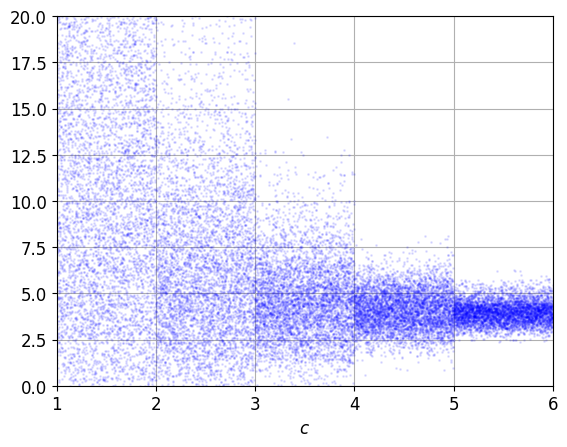

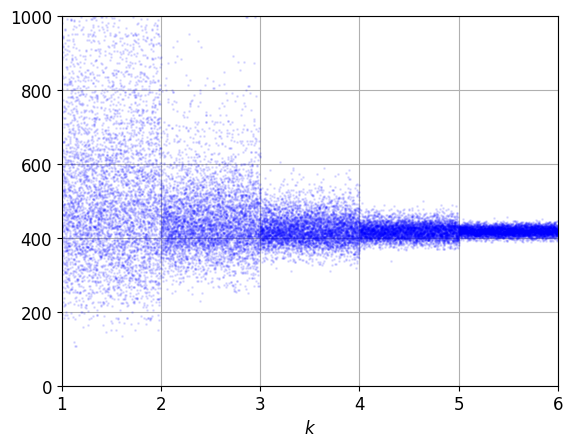

In [16]:
print(np.shape(Chain))
print(np.shape(Xsmp))

for ii in range(Npar):
  plt.figure(ii)
  plt.plot((1/Nsmp)*np.arange(0,len(Chain[ii,:])),Chain[ii,:],'b.',markersize=2,alpha=0.1)
  plt.ylim([X_low[ii],X_up[ii]])
  plt.xlim([1,6])
  plt.xlabel(mylabel[ii])
  plt.grid(True)


In [8]:
count = 0
for ii in range(len(Xsmp[0,:])):
    if Xsmp[0,ii] < 2:
        count = count + 1

print(count,len(Xsmp[0,:]))

0 5000


In [9]:
np.savetxt('muVec.dat',Xsmp)

statSmp = Xsmp.copy()
kdeMCMC= st.gaussian_kde(statSmp,bw_method = 0.1)
SigMat = kdeMCMC.covariance
np.savetxt('SigMat.dat',SigMat)

In [10]:
#np.savetxt('msd_0_samples.dat',Xsmp)
#np.savetxt('msd_0_chain.dat',Chain)

statSmp = Xsmp.copy()
kdeMCMC= st.gaussian_kde(statSmp,bw_method = 0.1)
SigMat = kdeMCMC.covariance
# np.savetxt('SigMat.dat',SigMat)

import scipy.stats as st
from scipy.optimize import minimize
kde = st.gaussian_kde(statSmp )
def kde_fun(x):
  return -kde(x)
res = minimize(kde_fun,phiTrue, method='nelder-mead',options={'xatol': 1e-8, 'disp': True})

maps = res.x
mean = np.mean(statSmp,axis=1)
#np.savetxt('Case01Model2-map.dat')
print(maps,mean)

Optimization terminated successfully.
         Current function value: -0.027495
         Iterations: 62
         Function evaluations: 126
[  3.93543859 415.4710923 ] [  3.98446318 418.836949  ]


0.19283850080052542


/tmp/ipykernel_73421/3280105116.py:8: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  Xpdf = st.kde.gaussian_kde(statSmp[j,:],bw_method = bandwidth[j])


0.19283850080052542


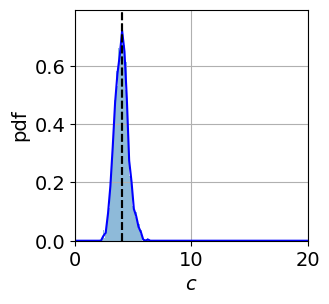

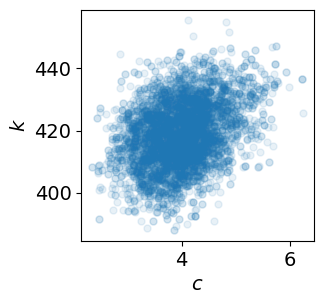

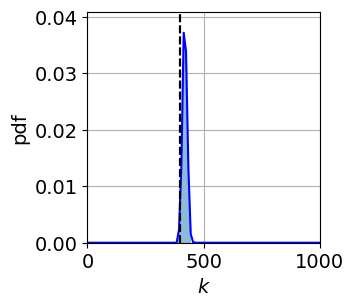

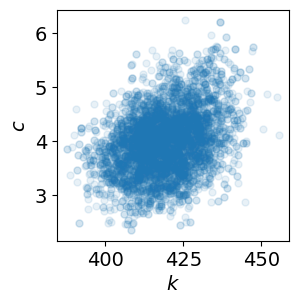

In [11]:
mpl.rcParams.update({'font.size':14})
statSmp = Xsmp
bandwidth = [0.1,0.1]

for j in range(0,Npar):
    f, ax = plt.subplots(1, figsize=(3,3))
    #Xpdf = st.kde.gaussian_kde(statSmp[j,:])
    Xpdf = st.kde.gaussian_kde(statSmp[j,:],bw_method = bandwidth[j])
    print(Xpdf.silverman_factor())
    Xgrd = np.linspace(np.min(statSmp[j,:]),np.max(statSmp[j,:]))
    Xgrd = np.linspace(X_low[j],X_up[j],100)
    plt.plot(Xgrd,Xpdf(Xgrd),'b-')
    plt.hist(statSmp[j,:], bins=50, density=True,alpha=0.5)
    pdfmax = max(Xpdf(Xgrd))
    myYlim = [0.0, 1.1*pdfmax]
    plt.plot([phiTrue[j],phiTrue[j]],myYlim,'--k',label='True')
    # plt.legend(loc='upper left', numpoints = 1)
    plt.plot([phiTrue[j],phiTrue[j]],myYlim,'--k')
    plt.ylabel('pdf')
    plt.xlabel(mylabel[j])
    #plt.xlim([np.min(statSmp[j,:]),np.max(statSmp[j,:])])
    plt.ylim(myYlim)
    plt.xlim([X_low[j],X_up[j]])
    # plt.yticks([])
    plt.grid(True)
    # plt.savefig('mpdf_'+str(j)+'.pdf',bbox_inches='tight')

    for jj in range(Npar):
        if j != jj:            
            f, ax = plt.subplots(1, figsize=(3,3))
            plt.scatter(statSmp[j,::1],statSmp[jj,::1],alpha=0.1,s=25)
            # plt.xlim([X_low[j],X_up[j]])
            # plt.ylim([X_low[jj],X_up[jj]])
            plt.xlabel(mylabel[j])
            plt.ylabel(mylabel[jj])
            # plt.ylim([0,5e5])
            # plt.xlim([0,8e5])
            # plt.savefig('figures/m1_jpdf_'+ str(ii)+str(jj)+'.pdf',bbox_inches='tight')
            # plt.close()

In [12]:
#np.savetxt('msd_0_samples.dat',Xsmp)
#np.savetxt('msd_0_chain.dat',Chain)

statSmp = Xsmp.copy()
kdeMCMC= st.gaussian_kde(statSmp,bw_method = 0.1)
SigMat = kdeMCMC.covariance
# np.savetxt('SigMat.dat',SigMat)

import scipy.stats as st
from scipy.optimize import minimize
kde = st.gaussian_kde(statSmp )
def kde_fun(x):
  return -kde(x)
res = minimize(kde_fun,phiTrue, method='nelder-mead',options={'xatol': 1e-8, 'disp': True})

maps = res.x
mean = np.mean(statSmp,axis=1)
#np.savetxt('Case01Model2-map.dat')
print(maps,mean)

Optimization terminated successfully.
         Current function value: -0.027495
         Iterations: 62
         Function evaluations: 126
[  3.93543859 415.4710923 ] [  3.98446318 418.836949  ]


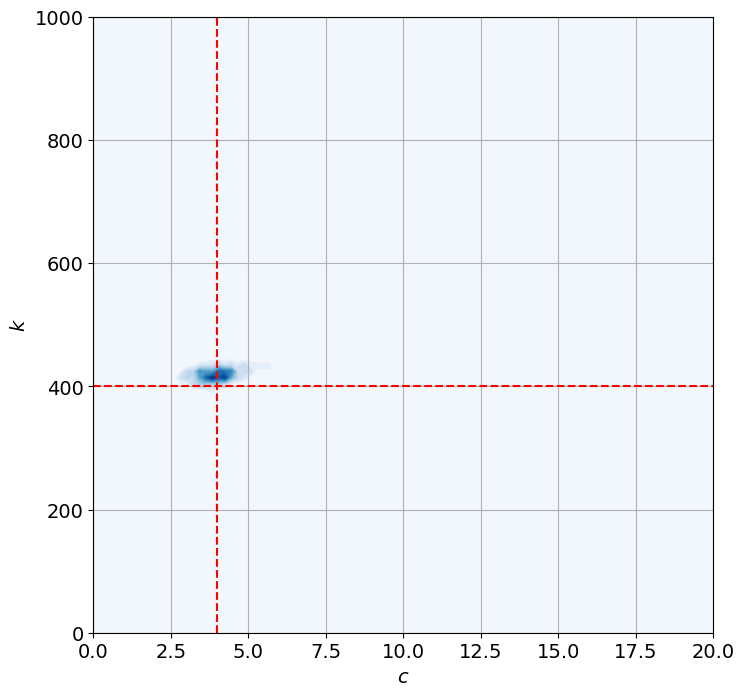

In [13]:
msize = 1.2
for i in range(0,Npar):
    for j in range(i+1,Npar):
        fig = plt.figure(Npar*i+j,figsize=(8,8))
        xmin = X_low[i]
        xmax = X_up[i]
        ymin = X_low[j]
        ymax = X_up[j]
        x = Xsmp[i,:]
        y = Xsmp[j,:]
        xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        values = np.vstack([x, y])
        kernel = st.gaussian_kde(values,bw_method = 0.1)
        f = np.reshape(kernel(positions).T, xx.shape)
        ax = fig.gca()
        # Contourf plot
        cfset = ax.contourf(xx, yy, f, 15,cmap='Blues')
        ## Or kernel density estimate plot instead of the contourf plot
        #ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
        # Contour plot
        #cset = ax.contour(xx, yy, f, colors='k')
        # Label plot
        #ax.clabel(cset, inline=1, fontsize=10)
        plt.plot([X_low[i],X_up[i]],[phiTrue[j],phiTrue[j]],'r--')
        plt.plot([phiTrue[i],phiTrue[i]],[X_low[j],X_up[j]],'r--')
        plt.xlabel(mylabel[i])
        plt.ylabel(mylabel[j])
        plt.xlim([xmin,xmax])
        plt.ylim([ymin,ymax])
        plt.grid(True)
        # plt.savefig('jpdf_post'+str(i+1)+str(j+1)+'.eps',bbox_inches='tight')

In [14]:
def Yresponse(parVecIn):
    dof = 1 # degree of freedom
    Y0   = [1,0] # initial conditions, [disp(3), vel(3)]
    mVec = [1] # mass vector
    cVec = [parVecIn[0]] # stiffness vector
    kVec = [parVecIn[1]] ##### modify this
    # kVec = [parVecIn[2],parVecIn[3]] ##### modify this
    Kmat = np.zeros((dof,dof))
    Cmat = np.zeros((dof,dof))
    Mmat = np.diag(mVec)
    Kmat[0,:] = [kVec[0]]
    Cmat[0,:] = [cVec[0]]
    Zmat = np.zeros((2*dof,2*dof))
    Zmat[0:dof,dof:] = np.diag([-1]*dof)
    Zmat[dof:,0:dof] = la.inv(Mmat)@Kmat
    Zmat[dof:,dof:] = la.inv(Mmat)@Cmat
    lamda,V = la.eig(Zmat)
    aVec = la.inv(V)@Y0
    Yresp = np.zeros((2*dof,tgrd_true))
    for i in range(0,tgrd_true):
        tempVec = np.exp(-lamda*tlist_true[i])
        lamdaMat = np.diag(tempVec)
        Yresp[:,i] = np.real(V@lamdaMat@aVec)
    return Yresp



mpl.rcParams.update({'font.size':12})
Ytrue = Yresponse(phiTrue)
Nreal = 1000
Yreal = np.zeros((2*dof,Nreal,tgrd_true))
Ystd = np.zeros((2*dof,tgrd_true))
Ymean = np.zeros((2*dof,tgrd_true))

# c_map = [4,400]

muVec = Xsmp
# Ymap = Yresponse(c_map)
for j in range(0,Nreal):
  Ysim = Yresponse(muVec[:,j*1])
  for i in range(2*dof):
    #Ysim = Yresponse([0,0,muVec[j]])
    Yreal[i,j,:] = Ysim[i,:]

for i in range(2*dof):
  Ystd[i,:] = np.std(Yreal[i,:,:],0)
  Ymean[i,:] = np.mean(Yreal[i,:,:],0)


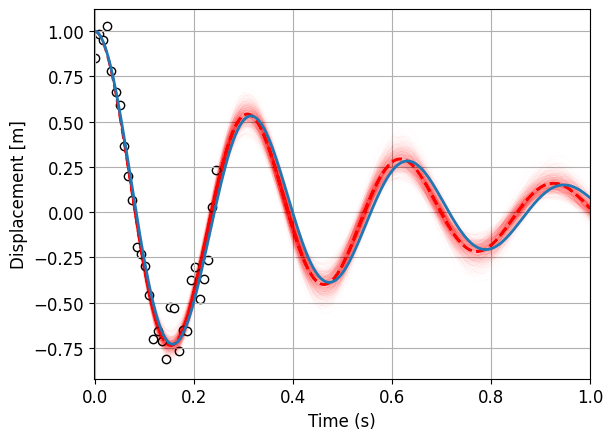

<Figure size 800x300 with 0 Axes>

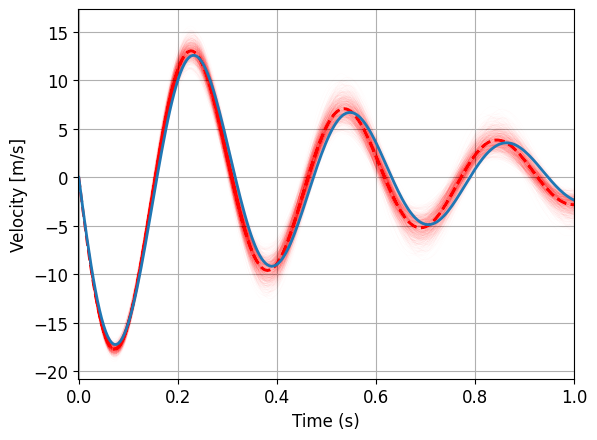

In [15]:
# for i in range(2*dof):
#   lwidth = 0.1
#   plt.figure(1,figsize=(8,3))
#   fig, ax = plt.subplots()
#   #plt.plot(tobs,Yobs,'k.',label='Observations')
#   plt.grid(True)
#   plt.xlabel('Time (s)')
#   plt.ylabel(r'Displacement: $u_1$')
#   plt.xlim([-0.001,T])
#   plt.plot(tlist,Ymean[i,:],color='tab:red',linestyle='--',linewidth=2,label='Predicted')
#   plt.plot(tlist,Yreal[i,:].T,linewidth=0.05,alpha=0.1,color='tab:red')
#   plt.plot(tlist,Ymean[i,:]+2*Ystd[i,:],color='tab:red',linestyle='--',linewidth=1.2,label='99/% region')
#   plt.plot(tlist,Ymean[i,:]-2*Ystd[i,:],color='tab:red',linestyle='--',linewidth=1.2)
#   # ax.fill_between(tlist, Y2, Y1, where=Y2 >= Y1, facecolor='pink', interpolate=True)
#   plt.plot(tlist,Ytrue[i,:],'tab:blue',linewidth=2,label = 'True')
#   plt.xlim([0,1])
#   # plt.ylim([-50,50])
#   plt.legend(loc='upper right', numpoints = 1)
#   plt.savefig('figs/predictions_before_dof_'+str(i)+'.pdf',bbox_inches='tight')

for i in range(2*dof):
  lwidth = 0.1
  plt.figure(1,figsize=(8,3))
  fig, ax = plt.subplots()
  #plt.plot(tobs,Yobs,'k.',label='Observations')
  plt.grid(True)
  plt.xlabel('Time (s)')
  plt.ylabel(mydof[i])
  plt.xlim([-0.001,T_true])
  if i == 0:
    plt.scatter(tobs,Yobs,color='w',edgecolor='k')
  plt.plot(tlist_true,Ymean[i,:],color='r',linestyle='--',linewidth=2,label='Predicted')
  plt.plot(tlist_true,Yreal[i,:].T,linewidth=0.05,alpha=0.1,color='r')
  # plt.plot(tlist,Ymean[i,:]+2*Ystd[i,:],color='tab:red',linestyle='--',linewidth=1.2,label='99/% region')
  # plt.plot(tlist,Ymean[i,:]-2*Ystd[i,:],color='tab:red',linestyle='--',linewidth=1.2)

  #   plt.legend(loc='upper right', numpoints = 1)
  # ax.fill_between(tlist, Y2, Y1, where=Y2 >= Y1, facecolor='pink', interpolate=True)
  plt.plot(tlist_true,Ytrue[i,:],'tab:blue',linewidth=2,label = 'True')
  #plt.xlim([0,T])
  # plt.ylim([-50,50])
  # plt.savefig('figs/predictions_before_dof_'+str(i)+'.pdf',bbox_inches='tight')